# Workspace \#7: ``model.py``

In [7]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from random import random

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md

In [9]:
# The contents of model.py
dir(md)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'ap',
 'ct',
 'ec',
 'np',
 'pt',
 'rt',
 'snr_routine']

In [26]:
# defining a test SNR
test_snr = dt.SuperNovaRemnant()
# test_snr.__dict__ = {
#     'age': 35000.,
#     'alpha': 0.7,
#     'gamma': 1.8,
#     'ang_size': 84.8528137423857,
#     'sr': 0.0004784858509023251,
#     'distance': 1.8,
#     'no_dist': False,
#     'l': 39.7,
#     'b': -2.,
#     'name': 'W50',
#     'snu_at_1GHz': 310.0,
#     'no_flux': False,
#     'type': 'S'}

test_snr.__dict__ = {
    'age': 36000.,
    'alpha': 0.7,
#     'alpha': 0.5,
    'gamma': ap.gamma_from_alpha(0.7),
    'ang_size': 48.0,
    'sr': 0.00015311679381005744,
    'distance': 1.9,
    'no_dist': False,
    'l': 6.4,
    'b': -0.1,
    'name': 'W28/G6.4-0.1',
    'snu_at_1GHz': 310.0,
    'no_flux': False,
    'type': 'S'}

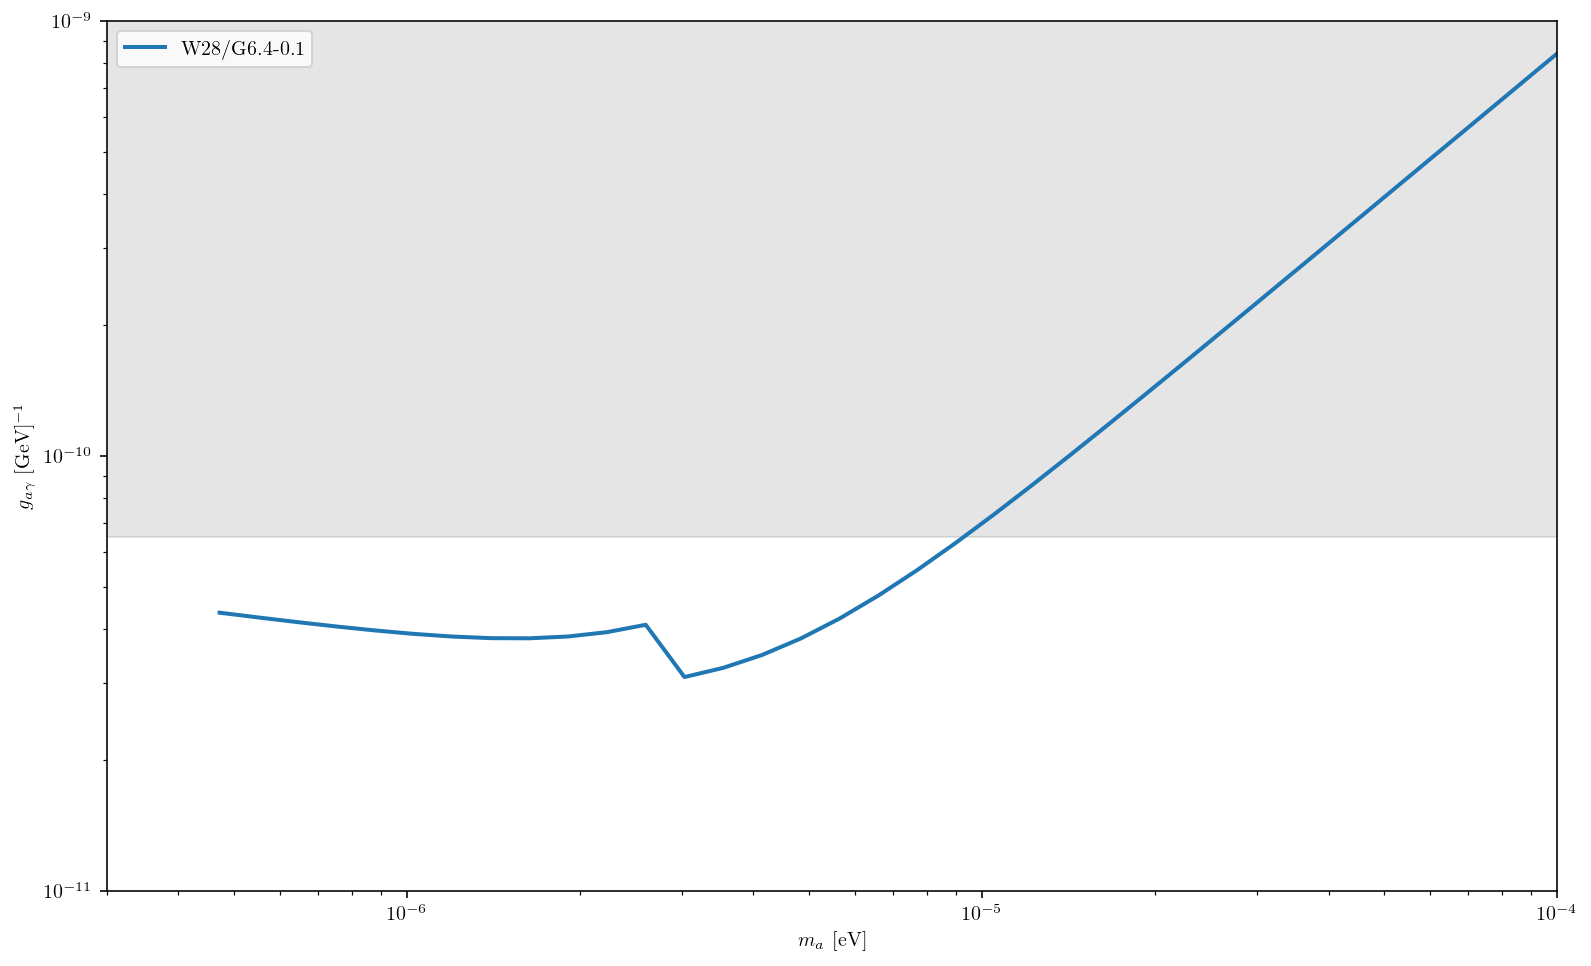

In [27]:
# t_extra_old = 5.e4
# t_extra_arr = [0., 2000., 1.e4]
t_extra_arr = [0.]
# t_age = None #set in snr.__dict__
t_trans_over_t_peak = 1.
ma_arr = np.logspace(np.log10(1e-7), np.log10(2e-4), 50)
sig_noi_thres = 1.
ga_ref = 1.e-10 # doesn't matter, will be rescaled

counter = 0
# best_snr = None
# best_ga = 1.# at first ma point

plt.subplots()
#for _, snr in tqdm(snrs_dct.items(), total=len(snrs_dct.keys())):

for idx, t_extra_old in enumerate(t_extra_arr):
    color = 'C'+str(idx)
    for snr in [test_snr]:
        
        try:
            distance = snr.get_distance()

        except:
            continue
        
#         L_peak = snr.Lpk
#         t_peak = snr.tpk
        
        tage = snr.age
        snu_echo_kwargs = {'tmin_default':None,
                           'Nt':100000, # for a fine enough array
                           'xmin':ct._au_over_kpc_,
                           'xmax_default':100.,
                           'use_quad':False,
                           'lin_space':False,
                           'Nint':100000, # for a fine enough array
                           't_extra_old':t_extra_old
                          }
        # data:
        data = {'deltaE_over_E':1.e-3,
                'f_Delta':0.721,
                'exp':'SKA',
                'total_observing_time':100.,
                'verbose':0, 
                'average':True
               }
        
        t_trans = 100.
        t_peak = t_trans*365.
        
        lightcurve_params = {'t_peak':t_peak,
#                              'L_peak':L_peak,
                             't_age':tage,
                             't_trans':t_trans,
                             'L_today':snr.get_luminosity()
                            }
        
        sig_noi = md.snr_routine(ma_arr, ga_ref,
                                 snr,
                                 lightcurve_params=lightcurve_params,
                                 snu_echo_kwargs=snu_echo_kwargs,
                                 data=data,
                                 output_all=False)
        
        ga_arr = ec.ga_reach(sig_noi_thres, sig_noi, ga_ref)
        
        plt.plot(ma_arr, ga_arr, lw='2.', color=color, alpha=1., label=snr.name)
        counter += 1

#         if best_ga > ga_arr[0]:
#             best_snr = snr
#             best_ga = ga_arr[0]
    #     if counter == 2:
    #         break

ga_cast = 6.5e-11
plt.fill_between([1e-7, 1e-2], ga_cast, 1, color='grey', alpha=0.2)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-9)
plt.xlim(3e-7, 1e-4)
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$g_{a\gamma}$ [GeV]$^{-1}$')
plt.legend(loc='best')


# title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}"
# title = title_str.format(D=snr.distance,
#                          log10Lpk=np.log10(snr.Lpk), 
#                          log10tpk=np.log10(snr.tpk),
#                          ell=snr.l,
#                          b=snr.b,
#                          alpha=snr.alpha,
#                          sn=sig_noi_thres)

# plt.title(title)

# print('ga_arr:',  ga_arr)

### Studying Green's Catalogue

In [19]:
verbose = 2
snr_results = {}

ga_ref = 1.e-10

tpk = 10.**(1.7)
Lpk = 10.**(28.)
t_trans_over_t_peak = 30.
t_trans = (tpk/365.)*t_trans_over_t_peak

for name, snr in dt.snrs_cut.items():
    
    lightcurve_params = {'t_peak':tpk,
                         'L_peak':Lpk,
                         't_trans':t_trans}
    
    snu_echo_kwargs = {'tmin_default':None,
                       'Nt':int(30001),
                       'xmin':ct._au_over_kpc_,
                       'xmax_default':100.,
                       'use_quad':False,
                       'lin_space':False,
                       'Nint':int(30001),
                       't_extra_old':0.
                      }
    # data:
    data = {'deltaE_over_E':1.e-3,
            'f_Delta':0.721,
            'exper':'SKA',
            'total_observing_time':100.,
            'verbose':0,
            'average':True
           }
    
    z, new_output = md.snr_routine(pt.ma_from_nu(1.), ga_ref,
                                   snr,
                                   lightcurve_params=lightcurve_params,
                                   snu_echo_kwargs=snu_echo_kwargs,
                                   data=data,
                                   output_all=True,
                                   verbose=verbose)
    
    snr_results[name] = new_output
    
    # obtaining L_today
    L0 = snr.get_luminosity() # [cgs]
    # computing t_age [years]
    print(ap.tage_compute(Lpk,
                          tpk,
                          t_trans,
                          L0,
                          ap.gamma_from_alpha(snr.alpha)))

SNR size=3.2e-06. Value will be respected.
signal power:1.73786966042e-19
noise power:9.61555148409e-17
s/n: 0.00180735308141

201.24038422609357
SNR size=3.3e-07. Value will be respected.
signal power:7.73253902268e-20
noise power:4.33292794766e-17
s/n: 0.00178459903236

64.69820769988002
SNR size=1.1e-06. Value will be respected.
signal power:5.38173579029e-19
noise power:5.46087780197e-17
s/n: 0.00985507456026

202.57146849074974
SNR size=6.4e-06. Value will be respected.
signal power:3.06787028466e-19
noise power:1.64083464194e-16
s/n: 0.00186970106935

264.83602763931225
SNR size=1.9e-05. Value will be respected.
signal power:1.08605408185e-19
noise power:2.46517624994e-16
s/n: 0.000440558390856

97.34612327216263
SNR size=4.3e-06. Value will be respected.
signal power:2.54979366639e-19
noise power:1.07653328229e-16
s/n: 0.00236852283932

337.2560003630851
SNR size=6.1e-05. Value will be respected.
signal power:1.33642044398e-18
noise power:4.04846242532e-16
s/n: 0.00330105680522
